In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap

import networkx as nx

from minimal.imaging import blit_rooms
from minimal.layout import LayoutGraph, NodeType
from minimal.gen import generate_plan, PlanMasks
from minimal import sample_graphs
from minimal.correction import RoomAreas

%matplotlib inline

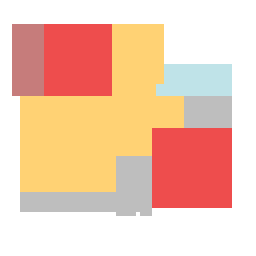

<PlanMasks 138817171781520>

In [3]:
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_01.pth"))
pm

In [4]:
%%time

min_area_units = 10
rooms = []
for i, node in enumerate(pm.graph.nodes):
    if not NodeType.is_room(node):
        continue

    room = RoomAreas(node, pm.masks[i])
    room.threshold_rectangles(min_area_units)
    room.discard_small_components()
    rooms.append(room)

CPU times: user 784 ms, sys: 898 µs, total: 785 ms
Wall time: 783 ms


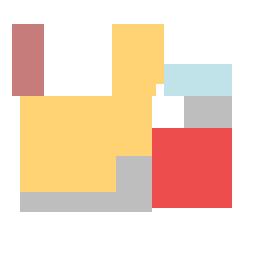

In [17]:
blit_rooms(rooms)

In [6]:
room_index_mask = sum(room.to_mask() * (i + 1) for i, room in enumerate(rooms))
room_index_mask.shape

torch.Size([64, 64])

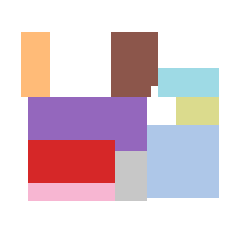

In [15]:
plt.figure(figsize=(3,3))
cmap = ListedColormap(['white', *plt.get_cmap('tab20').colors])
plt.axis("off")
plt.imshow(room_index_mask, cmap=cmap)

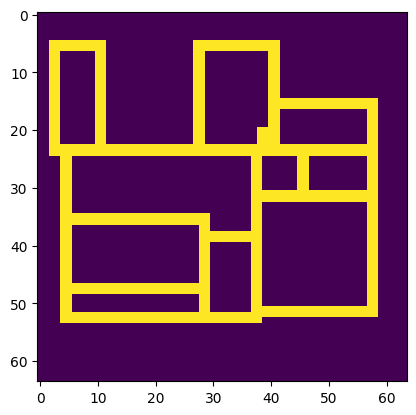

In [24]:
from scipy.ndimage import grey_dilation, grey_erosion

def detect_edges_morphological(image):
    # Perform dilation and erosion
    dilated = grey_dilation(image, size=(3, 3))
    eroded = grey_erosion(image, size=(3, 3))
    # Subtract to get edges
    edges = (dilated != eroded).astype(np.uint8)
    return edges

edges = detect_edges_morphological(room_index_mask)
plt.imshow(edges)